# **On_Prem Kubernetes SetUP**

*   Minimal install Ubuntu 22.04
*   Minimum 2 CPU cores / or 2 vCPU
*   20 GB free disk space on /var or more
*   Sudo user with admin rights
*   Internet connectivity on each node

# Set hostname on Each Node
Login to to master node and set hostname via hostnamectl command,

In [ ]:
sudo hostnamectl set-hostname "masternode"

On the worker nodes, run

In [ ]:
sudo hostnamectl set-hostname "worker-node01"   // 1st worker node
sudo hostnamectl set-hostname "worker-node02"   // 2nd worker node

Add the following lines in /etc/hosts file on each node

In [ ]:
10.1.130.140 masternode
10.1.130.141 worker-node01
10.1.130.142 worker-node02


# Disable Swap & Add kernel Parameters

Execute beneath swapoff and sed command to disable swap. Make sure to run the following commands on all the nodes


In [ ]:
sudo swapoff -a
sudo sed -i '/ swap / s/^\(.*\)$/#\1/g' /etc/fstab


Load the following kernel modules on all the nodes,

In [ ]:
sudo tee /etc/modules-load.d/containerd.conf <<EOF
overlay
br_netfilter
EOF


In [ ]:
sudo modprobe overlay
sudo modprobe br_netfilter


Set the following Kernel parameters for Kubernetes, run beneath tee command
Reload the above changes, run


In [ ]:
sudo tee /etc/sysctl.d/kubernetes.conf <<EOT
net.bridge.bridge-nf-call-ip6tables = 1
net.bridge.bridge-nf-call-iptables = 1
net.ipv4.ip_forward = 1
EOT


Reload the above changes, run

In [ ]:
sudo sysctl –system

# Install Containerd Runtime
In this guide, we are using containerd runtime for our Kubernetes cluster. So, to install containerd, first install its dependencies.


In [ ]:
sudo apt install -y curl gnupg2 software-properties-common apt-transport-https ca-certificates

Enable docker repository

In [ ]:
sudo curl -fsSL https://download.docker.com/linux/ubuntu/gpg | sudo gpg --dearmour -o /etc/apt/trusted.gpg.d/docker.gpg
sudo add-apt-repository "deb [arch=amd64] https://download.docker.com/linux/ubuntu $(lsb_release -cs) stable"


Now, run following apt command to install containerd

In [ ]:
sudo apt update
sudo apt install -y containerd.io


Configure containerd so that it starts using systemd as cgroup.

In [ ]:
containerd config default | sudo tee /etc/containerd/config.toml >/dev/null 2>&1
sudo sed -i 's/SystemdCgroup \= false/SystemdCgroup \= true/g' /etc/containerd/config.toml



Restart and enable containerd service


In [ ]:
sudo systemctl restart containerd
sudo systemctl enable containerd


# Add Apt Repository for Kubernetes
Kubernetes package is not available in the default Ubuntu 22.04 package repositories. So we need to add Kubernetes repository. run following command to download public signing key,


In [ ]:
curl -fsSL https://pkgs.k8s.io/core:/stable:/v1.28/deb/Release.key | sudo gpg --dearmor -o /etc/apt/keyrings/kubernetes-apt-keyring.gpg

Next, run following echo command to add Kubernetes apt repository.

In [ ]:
echo 'deb [signed-by=/etc/apt/keyrings/kubernetes-apt-keyring.gpg] https://pkgs.k8s.io/core:/stable:/v1.28/deb/ /' | sudo tee /etc/apt/sources.list.d/kubernetes.list

# Install Kubectl, Kubeadm and Kubelet
Post adding the repositories, install Kubernetes components like kubectl, kubelet and Kubeadm utility on all the nodes. Execute following set of commands,


In [ ]:
sudo apt update
sudo apt install -y kubelet kubeadm kubectl
sudo apt-mark hold kubelet kubeadm kubectl


# Install Kubernetes Cluster on Ubuntu 22.04

Now, we are all set to initialize Kubernetes cluster. Run the following Kubeadm command on the master node only.


In [ ]:
sudo kubeadm init --control-plane-endpoint=masternode

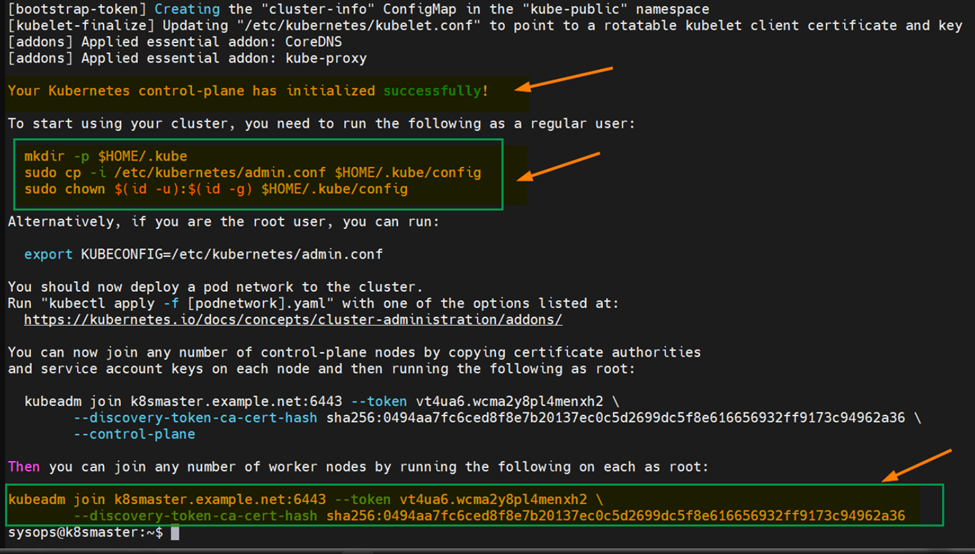

After the initialization is complete, you will see a message with instructions on how to join worker nodes to the cluster. Make a note of the kubeadm join command for future reference.
to start interacting with cluster, run following commands on the master node,


In [ ]:
mkdir -p $HOME/.kube
sudo cp -i /etc/kubernetes/admin.conf $HOME/.kube/config
sudo chown $(id -u):$(id -g) $HOME/.kube/config


# Join Worker Nodes to the Cluster
On each worker node, use the kubeadm join command you noted down earlier after initializing the master node on step 6. It should look something like this:


In [ ]:
# sample one
sudo kubeadm join k8smaster.example.net:6443 --token vt4ua6.wcma2y8pl4menxh2 \
   --discovery-token-ca-cert-hash sha256:0494aa7fc6ced8f8e7b20137ec0c5d2699dc5f8e616656932ff9173c94962a36


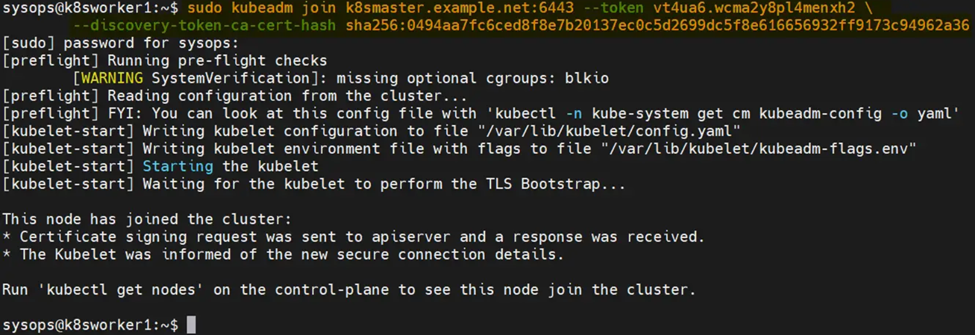

In [ ]:
kubectl get nodes

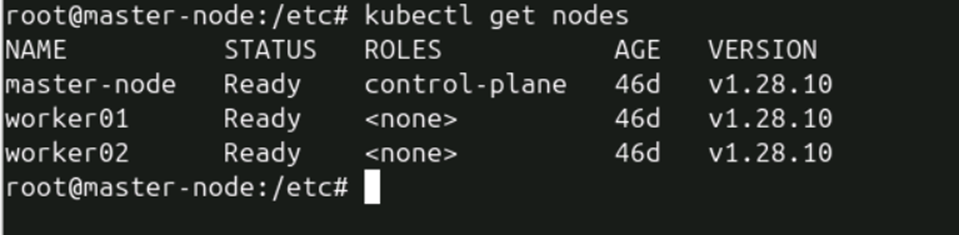

# Install Calico Network Plugin

A network plugin is required to enable communication between pods in the cluster. Run following kubectl command to install Calico network plugin from the master node,


In [ ]:
kubectl apply -f https://raw.githubusercontent.com/projectcalico/calico/v3.26.0/manifests/calico.yaml

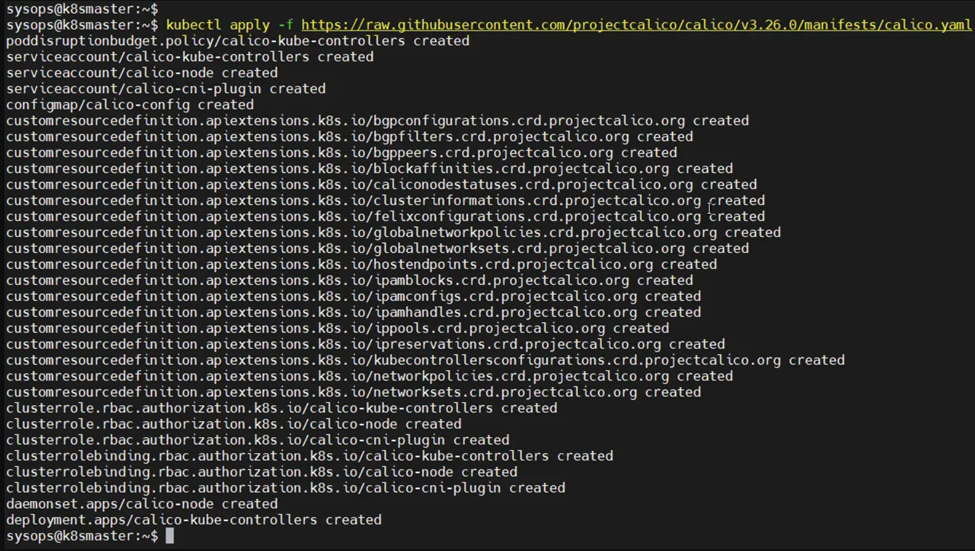